# End - to - End Multicalass Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I am sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is. 

## 2. Data

The data we are using is from Kaggle's dog breed identification competition (https://www.kaggle.com/c/dog-breed-identification/data).

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image. (https://www.kaggle.com/c/dog-breed-identification/overview/evaluation)

## 4. Features

Some information about the data:

- We are dealing with images (unstructured data) so it is probably best we use deep learning/transfer learning.
- There are 120 breeds of dogs (this means there are 120 different calsses).
- There are around 10000 + images in the training set (these images have labek).
- There are around 10000 + images in the test set (these images have no label, because we want to predict them).

In [0]:
# Unzip the uploaded data into Google Drive.
#!unzip "drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

### Get Our Workspace Ready

- Import TensorFlow 2.x
- Import TensorFlow Hub
- Make sure we are using a GPU

In [0]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version:", tf.__version__)
print("TF Hub Version:", hub.__version__)

# Check for GPU availability
print("GPU is available" if tf.config.list_physical_devices("GPU") else "GPU is not available")

TF Version: 2.2.0-rc3
TF Hub Version: 0.8.0
GPU is available


## Getting Our Data Ready (Turning into Tensors)

In [0]:
import pandas as pd

labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")

labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [0]:
labels_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [0]:
# How many images are there of each breed?
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


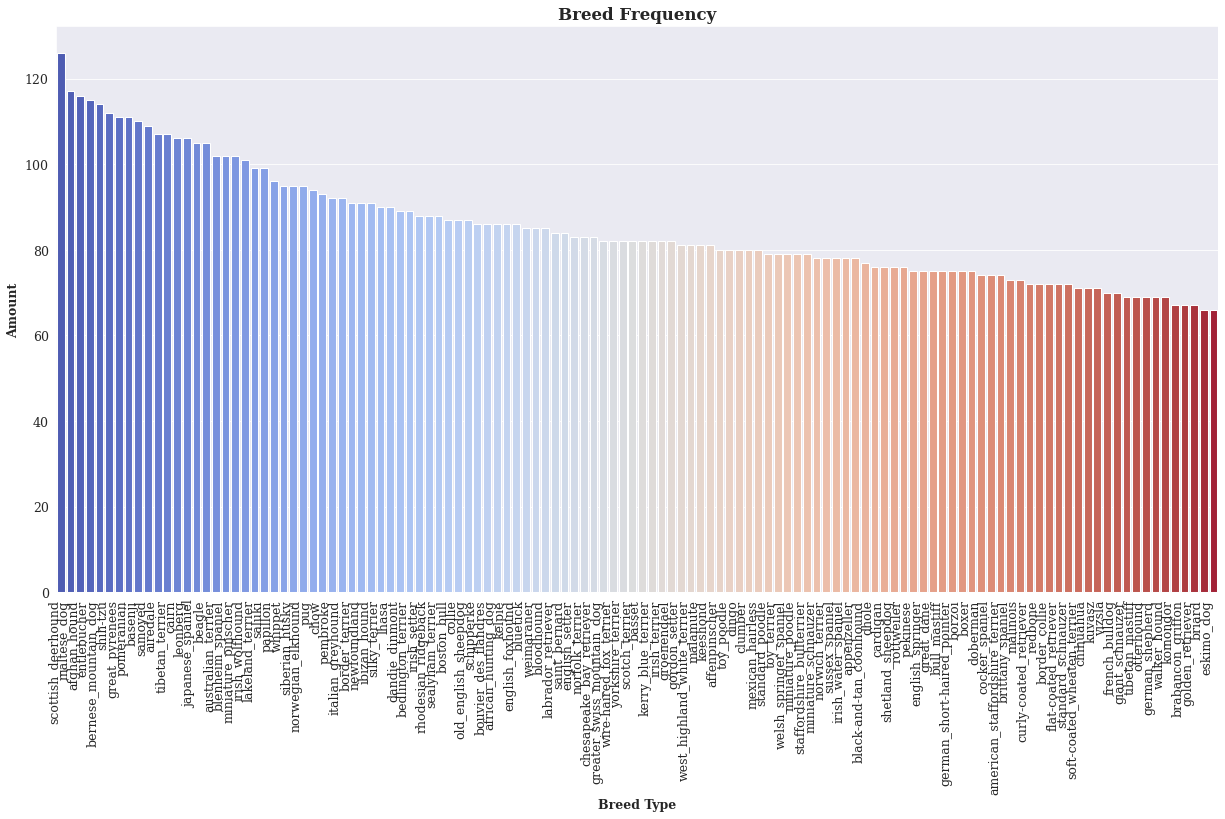

In [0]:
sns.set_style("darkgrid", {'font.family':'serif', 'font.serif':['Times New Roman']})

fig = plt.subplots(figsize = (20, 10), dpi = 75)

ax = sns.countplot(x = 'breed', data = labels_csv, palette = "coolwarm", order = labels_csv['breed'].value_counts().index);

ax.axes.set_title("Breed Frequency", fontsize=16, weight = 'bold')
ax.set_xlabel("Breed Type", fontsize = 12, weight = 'bold')
ax.set_ylabel("Amount", fontsize = 12, weight = 'bold')
ax.tick_params(labelsize = 12)
plt.xticks(rotation=90, ha='right');


In [0]:
labels_csv["breed"].value_counts().median()

82.0

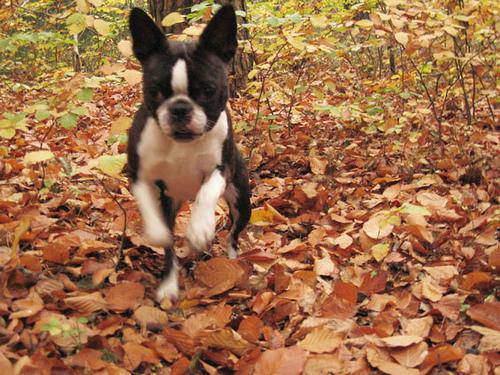

In [0]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg") 

### Getting Images abd Their Labels

Let's get of our image file pathnames

In [0]:
# Create pathnames from image ID's
filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

filenames[:10]


['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [0]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed")
else:
  print("Filenames does not match actual amount of files!!! Check the target directory.")

Filenames match actual amount of files!!! Proceed


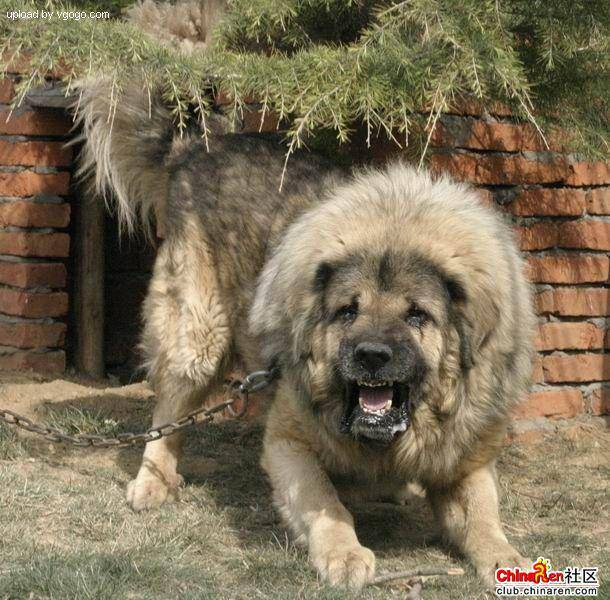

In [0]:
Image(filenames[9000])

In [0]:
labels_csv.breed[8000:8020]

8000              pomeranian
8001             boston_bull
8002        mexican_hairless
8003    bouvier_des_flandres
8004              bloodhound
8005              otterhound
8006    bouvier_des_flandres
8007                 samoyed
8008              rottweiler
8009       yorkshire_terrier
8010                  briard
8011         standard_poodle
8012              weimaraner
8013             groenendael
8014      standard_schnauzer
8015                pekinese
8016                pekinese
8017              eskimo_dog
8018         norwich_terrier
8019                bluetick
Name: breed, dtype: object

In [0]:
# Let's prepare our labels
import numpy as np

labels = labels_csv["breed"]
labels = np.array(labels)

len(labels)

10222

In [0]:
# See if the number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!!! Proceed")
else:
  print("Labels does not match the number of filenames!!! Check data directories.")

Number of labels matches number of filenames!!! Proceed


In [0]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [0]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [0]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [0]:
# Example: Turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0]))
print(np.argmax(unique_breeds == labels[0]))
print(np.argmax(boolean_labels))
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating our own validation set 

In [0]:
# Setup X & y variables
X = filenames
y = boolean_labels

We are going to start off experminting with ~1000 images and increase as needed

In [0]:
# Set number of images to use for experimening
num_images = 1000 #@param {type: "slider", min:1000, max: 10000, step: 1000}

In [0]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X[:num_images],
                                                      y[:num_images],
                                                      test_size = 0.2,
                                                      random_state = 42)

len(X_train), len(X_valid), len(y_train), len(y_valid)



(800, 200, 800, 200)

## Preprocessing Images (Turning Images into Tensors)

To process our images into Tensors, we are going to write a function which does a few things

1. Take an image filepath as input
2. Use TensorFlow to read the file and to save it to a variable; `image`
3. Turn our `image` (a jpg) into tensors.
4. Normalize our image (convert colour channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image` 

In [0]:
# Define image size
img_size = 224

# Create a function for processing images
def process_image(image_path, img_size = img_size):
  """
  Takes an image file path and turns image into a tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels = 3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value
  image = tf.image.resize(image, size = [img_size, img_size])

  return image


## Turning our data into batches

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples, which looks like this: `(image, label)`

In [0]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

Now we have got a way to turn our data into tuples of Tensors in the form of `(image, label)`, let us make a function to turn all of our data (X & y) into batches.

In [0]:
batch_size = 32

def create_data_batches(X, y = None, batch_size = batch_size, valid_data = False, test_data = False):
  """
  Create batches of data out of image (X) and label (y) pairs
  Shuffles the data if it is training data but does not shuffle if it is validation data
  Also accept test data as input (no labels)
  """
  if test_data:
    print("Creating test data batches ...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  elif valid_data:
    print("Creating valid data batches ...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  else:
    print("Creating training data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data = data.shuffle(buffer_size = len(X))
    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch


In [0]:
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data = True)

Creating training data batches
Creating valid data batches ...


## Visulizing databatches

In [0]:
def show_25_images(images, labels):
  """
  Display a plot of 25 images and their labels from a data batch
  """
  # Setup Figure
  plt.figure(figsize = (10, 10))
  
  #Loop through (for displaying 25 images)
  for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_breeds[labels[i].argmax()])
    plt.axis("off")


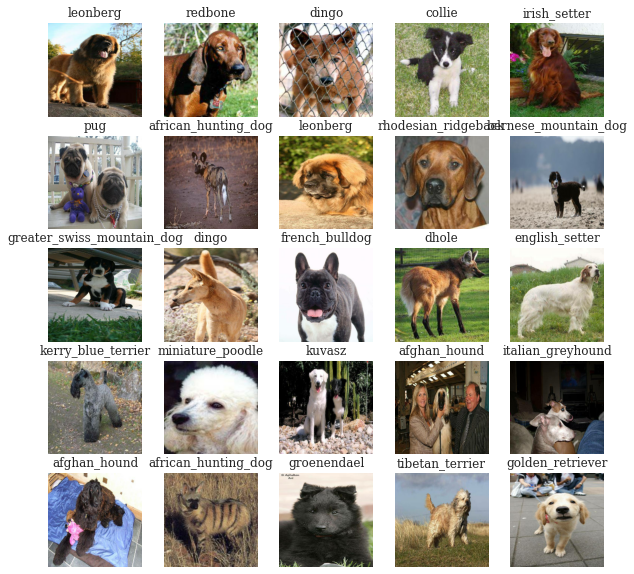

In [0]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

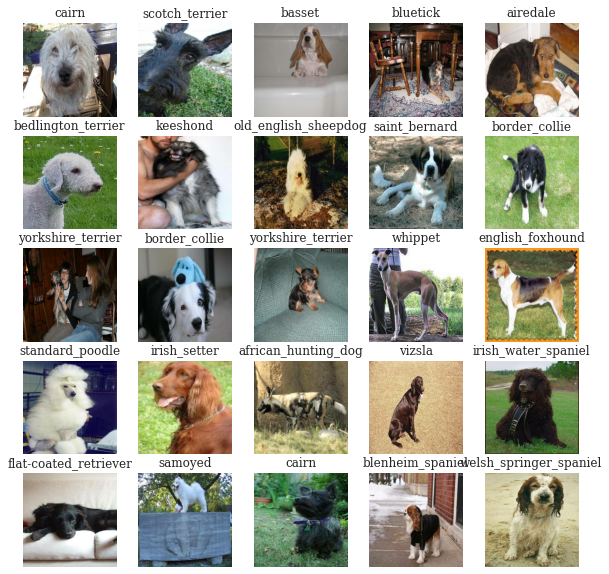

In [0]:
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
show_25_images(valid_images, valid_labels)

# Building A Model

Before we build a model, there are a few things we need to define:

1. The input shape (our images shape, in the form of Tensors)
2. The output shape (image labels, in the form of Tensors)
3. The URL of the model we want to use from TensorFlow Hub (https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4)

In [0]:
# Setup input shape to the model
input_shape = [None, img_size, img_size, 3] # [Batch size, Heigh, Width, Color channels]

# Setup output shape of our model
output_shape = len(unique_breeds)

# Setup model URL from TensorFlow Hub
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Let's create a function which:

- takes the input shape, output shape, and the model we have chosen as parameters
- Defines the layers in a Keras model in sequential fashion (do this first, then this, then that)
- Compiles the model (says it should be evaluated and improved)
- Builds the model (tells the model the input shape it will be getting)
- Returns the model

In [0]:
# Create a function which builds a Keras model
def create_model(input_shape = input_shape, output_shape = output_shape, model_url = model_url):
  print("Building model with: ", model_url)

  # Setup the model layers
  model = tf.keras.Sequential([hub.KerasLayer(model_url),
                               tf.keras.layers.Dense(units = output_shape,
                                                     activation = "softmax")])
  
  # Compile the model
  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])
  
  # Build the model
  model.build(input_shape)

  return model

In [0]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper fuctions a model can use during training to do such things as save its progress, check its progress, or stop training a model if a model stops improving.

We will create two callbacks, one for TensorBoard which help track our models progress for early stoping which prevents our model from training too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:

1. Load the TensorBoard extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit` function.
3. Visualize our models training logs with `tensorboard` magic function (we will do this after model training)

In [0]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a tensorboard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        datetime.datetime.now().strftime("%y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping callback

Early stopping helps our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 3)

## Training the model (on a subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [0]:
num_epochs = 100 #@param {type: "slider", min: 10, max: 100, step: 10}

In [0]:
# check to make sure we are still running on a GPU
print("GPU", "is available" if tf.config.list_physical_devices("GPU") else "is not available")

GPU is available


Let's create a function which trains a model:

- create a model using `create_model()`
- Setup a TensorBoard callback using `create_tensorboard_callback()`
- Call the `fit function` on our model passing it the training, validation data number of epochs to train and the callbacks we would like to use
- Return model

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """

  # Create a model
  model = create_model()

  # Create a new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x = train_data,
            epochs = num_epochs,
            validation_data = valid_data,
            validation_freq = 1,
            callbacks = [tensorboard, early_stopping])

  # Return the fitted model
  return model 

In [0]:
model = train_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 462s 18s/step - loss: 4.5539 - accuracy: 0.1063 - val_loss: 3.4575 - val_accuracy: 0.2800
Epoch 2/100
25/25 [==============================] - 5s 193ms/step - loss: 1.6495 - accuracy: 0.6650 - val_loss: 2.1870 - val_accuracy: 0.4750
Epoch 3/100
25/25 [==============================] - 5s 201ms/step - loss: 0.5670 - accuracy: 0.9325 - val_loss: 1.7084 - val_accuracy: 0.5700
Epoch 4/100
25/25 [==============================] - 5s 202ms/step - loss: 0.2622 - accuracy: 0.9850 - val_loss: 1.5467 - val_accuracy: 0.5900
Epoch 5/100
25/25 [==============================] - 5s 201ms/step - loss: 0.1519 - accuracy: 0.9962 - val_loss: 1.4729 - val_accuracy: 0.6100
Epoch 6/100
25/25 [==============================] - 5s 199ms/step - loss: 0.1012 - accuracy: 1.0000 - val_loss: 1.4333 - val_accuracy: 0.6150
Epoch 7/100
25/25 [=============================

**Question:** it looks like our model is overfitting because it is performing far better on the training dataset than the validation dataset. What are some ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing. It means our model is learning.

Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will accesss the logs directory we created earlier and visualize its contents.

In [0]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs

<IPython.core.display.Javascript object>

## Making and Evaluating Predictions Using A Trained Model

In [0]:
# Make the predictions on the validation data
predictions = model.predict(valid_data, verbose = 1)
predictions

7/7 [==============================] - 1s 129ms/step


array([[5.4121255e-03, 1.1802274e-04, 1.0885505e-03, ..., 5.5659155e-04,
        7.0993003e-05, 4.9508801e-03],
       [1.6540799e-03, 8.3166058e-04, 4.0428519e-02, ..., 1.0818159e-03,
        1.3798698e-04, 1.6288909e-04],
       [1.5417128e-05, 1.2761625e-05, 6.8910711e-05, ..., 5.4562970e-06,
        1.0224272e-04, 5.7870912e-04],
       ...,
       [3.2253127e-05, 1.0044582e-04, 1.0614364e-04, ..., 2.2353619e-05,
        8.8338384e-05, 1.4270064e-04],
       [4.9137287e-03, 5.7769642e-04, 2.9188191e-04, ..., 5.5416161e-04,
        3.6170869e-04, 1.9191111e-02],
       [1.1113111e-04, 2.5694502e-05, 5.3624972e-04, ..., 7.6955190e-04,
        5.3996075e-04, 1.5418540e-04]], dtype=float32)

In [0]:
predictions.shape

(200, 120)

**Note:** Prediction probabilities are also known as confidence level

In [0]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into labels
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

Now since our validation data is still in a batch dataset, we will have to unbatchify to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [0]:
# Create a function to unbatch a batch dataset
def unbatchify (data):
  """
  Takes abatched dataset of (image, label) Tensors and returns separate arrays of images and labels
  """
  images = []
  labels = []

  # Loops through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

# Unbatchify the validation data
valid_images, valid_labels = unbatchify(valid_data)


Now we have got ways to get

- Prediction labels
- Validation labels (Truth images)
- Validation images

Let's make a function to make these all a bit more visualize

We will create a function which

- Takes an array of prediction probabilities, an array of truth labels, and an array of images and integer
- Convert the prediction probabilities to a predicted label
- Plot the predicted label, its predicted probability, the truth label, and the target image on a single plot

In [0]:
def plot_pred(prediction_probabilities, labels, images, n = 1):
  """
  View the prediction, ground truth, and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot titlet to be predicted probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob) * 100,
                                    true_label),
            color = color)

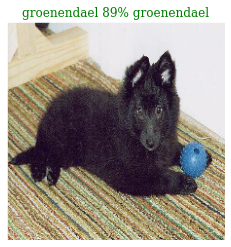

In [0]:
plot_pred(prediction_probabilities = predictions,
          labels = valid_labels,
          images = valid_images,
          n = 77)

Now we have got one function to visualize our models top 10 predictions.

This function will:
- Take an input of prediction probabilities array and aground truth array and an integer
- Find the prediction using `get_pred_label()`
- Find the top 10
  * Prediction probabilities indexes
  * Prediction Probabilities values
  * Prediction labels
- Plot the top 10 prediction probability values and labels, coloring the true label green

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n =1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for sample n
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color = 'red')
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation = 'vertical')
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

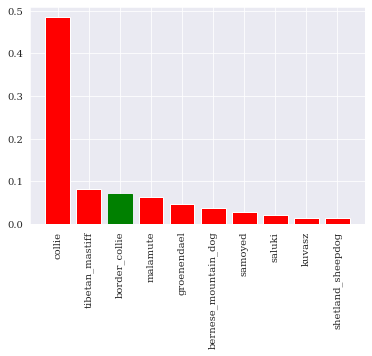

In [0]:
plot_pred_conf(prediction_probabilities = predictions,
               labels = valid_labels,
               n =9)

Let's checkout a few predictions and their different values 

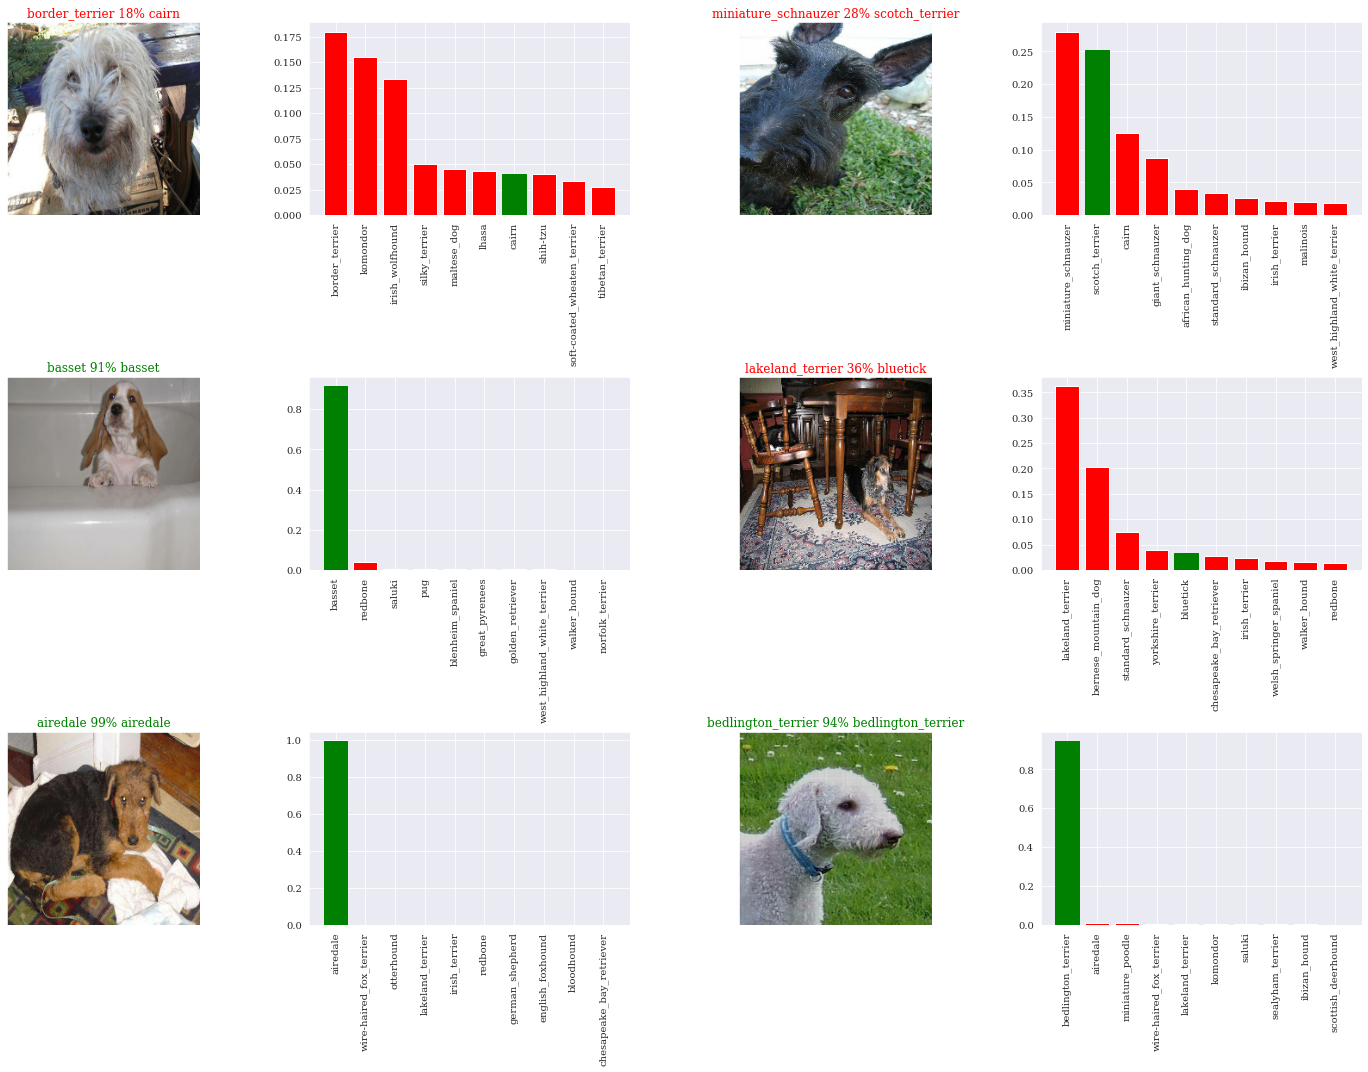

In [0]:
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols

plt.figure(figsize = (10 * num_cols, 5 * num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  plot_pred(prediction_probabilities = predictions,
            labels = valid_labels,
            images = valid_images,
            n = i + i_multiplier)
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
  plot_pred_conf(prediction_probabilities = predictions,
                 labels = valid_labels, n =i + i_multiplier)

plt.tight_layout(h_pad = 1)
plt.show()


## Saving and reloading a model

In [0]:
# Create a function to save a model
def save_model(model, suffix = None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [0]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loads saved model from: {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects = {"KerasLayer": hub.KerasLayer})
  return model

In [0]:
# Save our model trained on 1000 images
save_model(model, suffix = "1000-images-mobilenetv2-Adam")

Saving model to: drive/My Drive/Dog Vision/models/20200417-13101587129031-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200417-13101587129031-1000-images-mobilenetv2-Adam.h5'

In [0]:
# Load a trained model
loaded_1000_image_model = load_model("drive/My Drive/Dog Vision/models/20200416-23141587078859-1000-images-mobilenetv2-Adam.h5")

Loads saved model from: drive/My Drive/Dog Vision/models/20200416-23141587078859-1000-images-mobilenetv2-Adam.h5...


In [0]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(valid_data)

7/7 [==============================] - 1s 128ms/step - loss: 1.3007 - accuracy: 0.6400


[1.3006821870803833, 0.6399999856948853]

In [0]:
# Evaluate the pre-saved model
model.evaluate(valid_data)

7/7 [==============================] - 1s 120ms/step - loss: 1.3439 - accuracy: 0.6300


[1.3438729047775269, 0.6299999952316284]

Training a big model on the full data

In [0]:
# Creating a data batch with the full data
full_data = create_data_batches(X, y)

full_model = create_model()

Creating training data batches
Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',
                                                             patience = 3)

In [0]:
full_model.fit(x = full_data,
               epochs = num_epochs,
               callbacks = [full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 4885s 15s/step - loss: 1.3446 - accuracy: 0.6686
Epoch 2/100
320/320 [==============================] - 51s 160ms/step - loss: 0.4020 - accuracy: 0.8808
Epoch 3/100
320/320 [==============================] - 51s 160ms/step - loss: 0.2344 - accuracy: 0.9361
Epoch 4/100
320/320 [==============================] - 51s 160ms/step - loss: 0.1534 - accuracy: 0.9626
Epoch 5/100
320/320 [==============================] - 51s 159ms/step - loss: 0.1078 - accuracy: 0.9785
Epoch 6/100
320/320 [==============================] - 51s 159ms/step - loss: 0.0769 - accuracy: 0.9859
Epoch 7/100
320/320 [==============================] - 51s 158ms/step - loss: 0.0582 - accuracy: 0.9920
Epoch 8/100
320/320 [==============================] - 50s 158ms/step - loss: 0.0468 - accuracy: 0.9935
Epoch 9/100
320/320 [==============================] - 51s 158ms/step - loss: 0.0382 - accuracy: 0.9959
Epoch 10/100
320/320 [==============================] - 51s 160m

In [0]:
save_model(full_model, suffix = 'full-image-set-mobilenetv2-Adam')

Saving model to: drive/My Drive/Dog Vision/models/20200417-14581587135508-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200417-14581587135508-full-image-set-mobilenetv2-Adam.h5'

In [0]:
#Load in the full model
loaded_full_model = load_model('drive/My Drive/Dog Vision/models/20200417-14581587135508-full-image-set-mobilenetv2-Adam.h5')

Loads saved model from: drive/My Drive/Dog Vision/models/20200417-14581587135508-full-image-set-mobilenetv2-Adam.h5...


## Making Predictions on the test dataset

Since our model has been trained on images in the format of Tensor batches, to make predictions on the test data, we will have to get it in the same format

Lockily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into Tensor batches

To make predictions on the test data, we will:

- Get the test image filenames
- Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (Since the data does not have labels)
- Make a predictions array by passing the test batches to the `predict` method called on our model

In [0]:
# Load test image filenames
test_path = "drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['drive/My Drive/Dog Vision/test/eb61a828e939eb633c1811f283d15647.jpg',
 'drive/My Drive/Dog Vision/test/ea6005562757cf5a7a37d70134d28870.jpg',
 'drive/My Drive/Dog Vision/test/ee878152e29a6b6ce288b44b358f9d05.jpg',
 'drive/My Drive/Dog Vision/test/f5a6e430c2c363335d22ae0593d7533a.jpg',
 'drive/My Drive/Dog Vision/test/efd7f925e6ce41da800844e6aae03226.jpg',
 'drive/My Drive/Dog Vision/test/f53c0a1ab2af3549a2ef5825d023b160.jpg',
 'drive/My Drive/Dog Vision/test/f0138bdbeba02c23bef5eebd81fcf3ec.jpg',
 'drive/My Drive/Dog Vision/test/f04afba75c6b505c74c9958aa8aabffa.jpg',
 'drive/My Drive/Dog Vision/test/e8d27c76d6921b27aea1e2da6920396f.jpg',
 'drive/My Drive/Dog Vision/test/f372b595f5e684d8c7c261d6b0166736.jpg']

In [0]:
test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches ...


In [0]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose = 1)

324/324 [==============================] - 5144s 16s/step


In [0]:
# Save predictions (Numpy array) to csv file (for later access)
np.savetxt("drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter= ",")

In [0]:
# Load predictions (Numpy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter = ",")

In [0]:
test_predictions

array([[1.53753068e-13, 5.38989305e-11, 6.19269523e-12, ...,
        4.17152146e-11, 4.45024906e-09, 1.58497987e-12],
       [1.43259916e-12, 3.88399556e-11, 1.17947622e-12, ...,
        6.70946187e-10, 1.00677688e-10, 4.88841856e-09],
       [7.86895826e-02, 9.80627723e-04, 3.02918522e-07, ...,
        3.71384522e-06, 1.20052971e-06, 7.79986476e-06],
       ...,
       [1.98102372e-13, 1.14796528e-07, 4.46645637e-11, ...,
        1.37984524e-12, 8.87541027e-15, 4.41665064e-12],
       [9.78051412e-06, 2.10670890e-12, 5.96470627e-13, ...,
        8.65351735e-10, 8.84090523e-10, 4.28690640e-07],
       [1.58271640e-09, 1.13694565e-09, 5.04446374e-10, ...,
        3.82794987e-08, 1.97937309e-11, 4.76228224e-11]])

## Preparing the test dataset prediction for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we will:

- Create a pandas DataFrame with an ID column as well as a column for each dog breed
- Add data to the ID column by extracting the test image ID's from their filepaths
- Add data (the prediction probabilities) to each of the dog breed columns.
- Export the DataFrame as a CSV to submit it to the Kaggle

In [0]:
# Create a panda DataFrame with empty columns
preds_df = pd.DataFrame(columns = ["id"] + list(unique_breeds))

# Append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions

preds_df.head()

id  ... yorkshire_terrier
0  eb61a828e939eb633c1811f283d15647  ...       1.58498e-12
1  ea6005562757cf5a7a37d70134d28870  ...       4.88842e-09
2  ee878152e29a6b6ce288b44b358f9d05  ...       7.79986e-06
3  f5a6e430c2c363335d22ae0593d7533a  ...       5.65051e-13
4  efd7f925e6ce41da800844e6aae03226  ...       3.47692e-09

[5 rows x 121 columns]

In [0]:
# Save our predictions DataFrame to csv for submission to Kaggle
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_predictions_submission_1_mobilenetv2.csv",
                index = False)

# Making predictions on custom images
To make predictions oncustom images we will,

- Get the filepaths of our own images
- Turn the filepaths into data batches using `create_data_batches()`. Since our custom images would not have labels, we set the `test_data` parameter to True
- pass the custom image data batch to our model's `predict` method().
- Convert the prediction output probabilities to prediction labels
- Compare the predicted labels to the custom images.

In [120]:
custom_path = "drive/My Drive/Dog Vision/my-dog-photos/"
custom_filenames = [custom_path + fname for fname in os.listdir(custom_path)]
custom_data = create_data_batches(custom_filenames[:2], test_data = True)
custom_preds = loaded_full_model.predict(custom_data)

Creating test data batches ...


In [121]:
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['papillon', 'border_collie']

In [0]:
custom_images = []
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

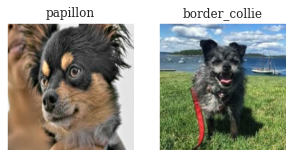

In [123]:
plt.figure(figsize = (5, 5))
for i, image in enumerate(custom_images):
  plt.subplot(1, 2, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)